# Investigating adjusted p-values from 0ppm vs 1500ppm eQTL analysis

__Author:__ Bryan Quach  
__Date:__ April 28, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney. The phenotype was the normalized expression differences between 1500ppm and 0ppm BD treated CC mice.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [1]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/0ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/0ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/0ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mg

## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [2]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

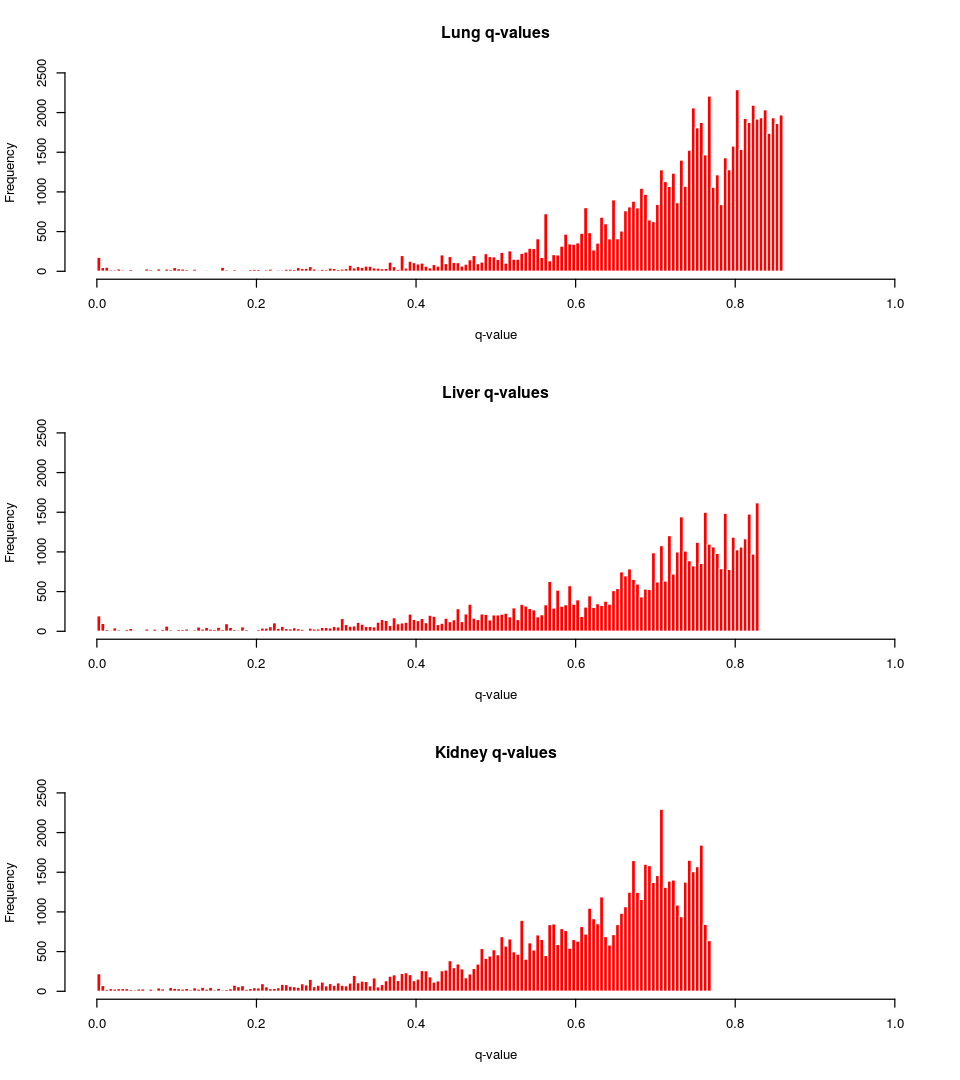

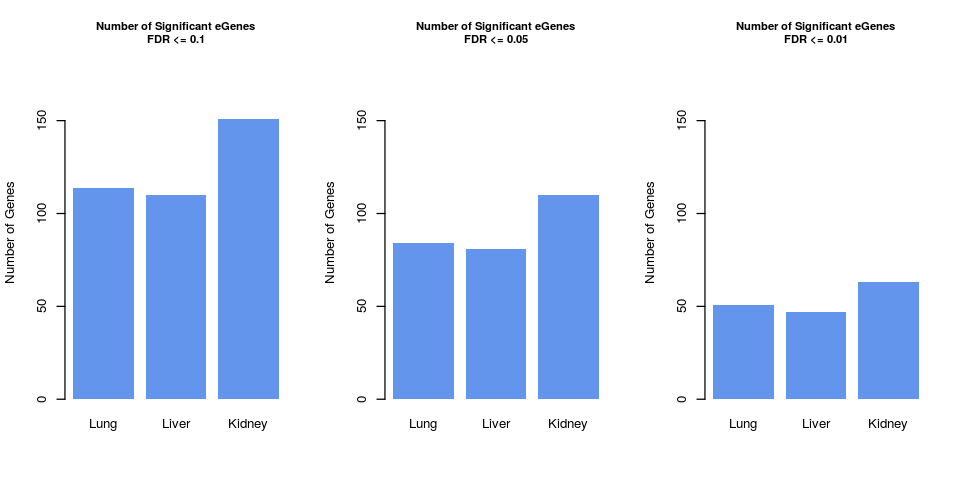

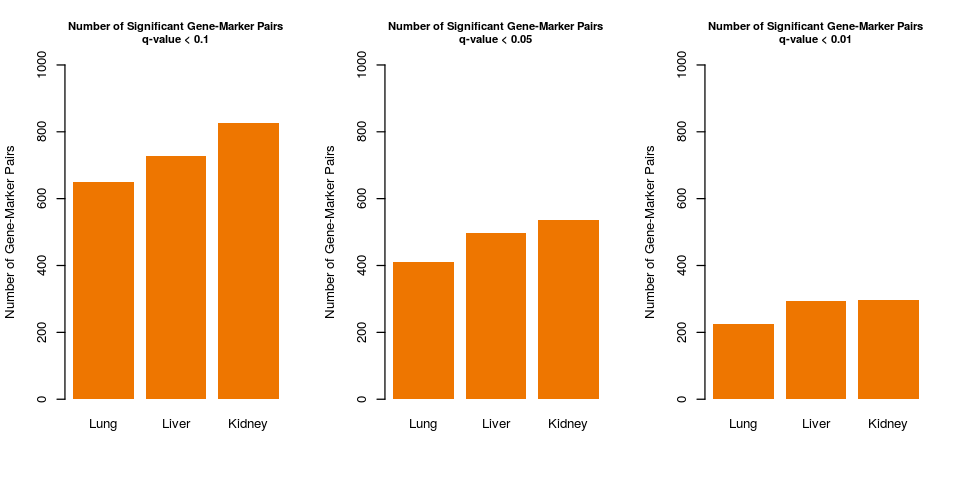

In [3]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,2500), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,2500), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,2500), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,180),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,180),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,180),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [4]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/0ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/0ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/0ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals_0_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals_0_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals_0_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene      marker                               chr   start     end      
5010  Surf1     UNC2761572.JAX00092339               chr2  25674499  25943992 
5081  Surf1     UNC2765102.UNC2767477                chr2  25954670  26146748 
5143  Surf1     JAX00485655.UNC2769505               chr2  26152118  26389312 
11776 Wnt2b     UNC5891025.UNC5917724                chr3  104575861 107196597
67899 Ppp1r14b  JAX00469668.UNC29855954              chr19 6571054   6902721  
67974 Ppp1r14b  UNC29856661.UNC29864970              chr19 6982911   7933354  
68043 Ppp1r14b  UNC29865283.UNC29865283              chr19 8014692   8014692  
4716  C8g       UNC2746803.UNC2747334                chr2  24531371  24562440 
21053 Styxl1    UNC10243742.UNC10244171              chr5  136017898 136044478
21012 Styxl1    UNC10239614.JAX00598489              chr5  135749244 136009203
56851 Ly6f      UNC25888851.UNC25895704              chr15 74042551  74542039 
56885 Ly6f      UNC25896223.UNC25904367              chr15 74595504  75277140 
20927 Styxl1    JAX00136067.UNC10236173              chr5  135371333 135447354
21092 Styxl1    UNC10244622.UNC10246662              chr5  136072634 136229777
14061 Cyp2j6    UNC7778493.UNC7800092                chr4  95319709  97179525 
14074 Cyp2j6    UNC7800165.UNC7802608                chr4  97184253  97383323 
11714 Wnt2b     UNC5888495.UNC030164357              chr3  104381592 104559516
51741 Serpinb6c UNC22378305.JAX00354323              chr13 33059129  33163127 
51760 Serpinb6c backupJAX00354324.JAX00354524        chr13 33163208  34462094 
51781 Serpinb6c UNC22394212.UNC22409068              chr13 34521187  35653955 
51727 Serpinb6c UNC22370249.UNC22378085              chr13 31941897  33035493 
62161 Srrm2     JAX00433060.B6_17_023744030_S        chr17 19565308  23744030 
26734 Cyp2b13   UNC12521588.UNC12531236              chr7  27079399  28104183 
26693 Cyp2b13   UNC12521377.UNC12521377              chr7  27033384  27033384 
59725 Mb21d2    UNC26532657.UNC26542096              chr16 27360815  27974227 
59731 Mb21d2    UNC26542724.UNC26558846              chr16 28024349  29058769 
59738 Mb21d2    JAX00416731.UNC26559231              chr16 29062932  29087343 
59748 Mb21d2    JAX00067795.UNC26565530              chr16 29097816  29501787 
39695 H60c      B6_10_004862788_S.backupUNC100008688 chr10 4862788   6819624  
30902 Asphd1    UNC13808080.UNC13808351              chr7  134137007 134181453
⋮     ⋮         ⋮                                    ⋮     ⋮         ⋮        
39716 H60c      JAX00014634.UNC17374593              chr10 7165957   7674623  
55311 Adamdec1  UNC24171088.UNC24176426              chr14 68589757  68963350 
61226 Cbr3      UNC27419473.UNC27424733              chr16 93339175  93666374 
59598 Kng2      UNC26469272.UNC26472626              chr16 22819690  23062676 
55293 Adamdec1  UNC24154965.UNC24170250              chr14 67451691  68535493 
59557 Kng2      JAX00415604.JAX00415604              chr16 22676983  22676983 
59578 Kng2      JAX00415607.UNC26468332              chr16 22696026  22759284 
39734 H60c      CEAJAX00014673.UNC17387979           chr10 7777365   8539327  
65298 Cdc25c    UNC29006931.UNC29022978              chr18 32982540  34146798 
65330 Cdc25c    UNC29023372.UNC29023821              chr18 34165122  34210456 
65351 Cdc25c    UNC29023900.UNC29023900              chr18 34213715  34213715 
59863 Snx4      UNC160035995.UNC26602350             chr16 32021102  32612139 
59898 Snx4      UNC160202433.UNC160203517            chr16 32695806  32984004 
54386 Anxa8     UNC23825504.UNC23826071              chr14 34559712  34585811 
54399 Anxa8     UNC23826331.UNC23826890              chr14 34606242  34633169 
54412 Anxa8     backupUNC140121600.UNC23831316       chr14 34648127  34898263 
54426 Anxa8     UNC23831510.UNC23861847              chr14 34910532  37292081 
59965 Snx4      UNC26611901.UNC26632751              chr16 33349818  34848858 
59930 Snx4      UNC26606735.UNC160297022             chr

Liver


gene          marker                        chr   start     end      
48098 Slc22a28      UNC29870082.UNC29870082       chr19 8879987   8879987  
48132 Slc22a28      JAX00086716.JAX00086716       chr19 8884936   8884936  
48166 Slc22a28      UNC29870159.UNC29870159       chr19 8890053   8890053  
48200 Slc22a28      UNC29870238.UNC29870238       chr19 8901566   8901566  
48234 Slc22a28      UNC29870343.UNC29870343       chr19 8915310   8915310  
48268 Slc22a28      UNC29870437.UNC29870437       chr19 8926210   8926210  
48302 Slc22a28      UNC29870591.UNC29870591       chr19 8940770   8940770  
48336 Slc22a28      UNC29870739.UNC29870739       chr19 8951909   8951909  
48370 Slc22a28      UNC29870891.UNC29870891       chr19 8963267   8963267  
48404 Slc22a28      UNC29870993.UNC29871077       chr19 8975822   8990729  
47924 Slc22a28      UNC29869217.UNC29869217       chr19 8783288   8783288  
47959 Slc22a28      UNC29869312.UNC29869312       chr19 8796311   8796311  
47994 Slc22a28      UNC29869483.UNC29869587       chr19 8810405   8820592  
47889 Slc22a28      JAX00469956.UNC29869053       chr19 8655244   8771865  
47855 Slc22a28      UNC29867469.UNC29867469       chr19 8600467   8600467  
4758  Rad51         UNC3827172.UNC020151798       chr2  117902317 118821150
48574 Slc22a28      UNC29871907.JAX00470030       chr19 9096225   9183879  
48472 Slc22a28      UNC29871338.UNC29871338       chr19 9028051   9028051  
48506 Slc22a28      UNC29871426.UNC29871426       chr19 9037801   9037801  
48539 Slc22a28      UNC29871593.UNC29871593       chr19 9054951   9054951  
48438 Slc22a28      UNC29871139.UNC29871202       chr19 9001604   9011153  
48029 Slc22a28      UNC29869670.UNC29869670       chr19 8831659   8831659  
47584 Pygm          JAX00469668.UNC29855954       chr19 6571054   6902721  
47640 Pygm          UNC29856661.UNC29864970       chr19 6982911   7933354  
43860 Tff3          UNC27753023.UNC27767093       chr17 30047121  31280270 
43681 Ppard         UNC27722618.UNC27722769       chr17 27493965  27513413 
43708 Ppard         UNC27722978.UNC27723391       chr17 27532447  27572669 
43647 Ppard         UNC27715265.JAX00434785       chr17 26794469  27483027 
6070  Mir6340       UNC4531549.UNC4536733         chr2  172670737 172965050
6121  Mir6340       UNC4540460.UNC4545629         chr2  173176283 173497619
⋮     ⋮             ⋮                             ⋮     ⋮         ⋮        
1425  Ren1          UNC1685599.backupUNC010608551 chr1  133661417 134411810
6716  Mgst2         UNC5241131.UNC5241131         chr3  50542803  50542803 
19516 Snord32a      UNC12730093.UNC12733421       chr7  52695471  52985745 
19577 Snord32a      UNC12733892.UNC12750077       chr7  53013200  54037198 
13951 Myl2          UNC10027431.UNC050201332      chr5  120362630 122079807
7028  Asic5         UNC5634552.JAX00527982        chr3  80967068  81159299 
45741 Egr1          UNC29023900.UNC29023900       chr18 34213715  34213715 
45727 Egr1          UNC29023372.UNC29023821       chr18 34165122  34210456 
45705 Egr1          UNC29006931.UNC29022978       chr18 32982540  34146798 
7032  Asic5         UNC5637994.UNC5646492         chr3  81164148  81784771 
7036  Asic5         JAX00109616.JAX00528118       chr3  81809196  81943896 
7044  Asic5         UNC5649037.UNC5663586         chr3  81948614  82909885 
14698 Zfand2a       UNC10291007.UNC10306321       chr5  139780797 140933260
1470  Ren1          UNC1707230.UNC1707230         chr1  135335207 135335207
7021  Asic5         JAX00109485.UNC5633281        chr3  80065646  80902341 
42307 St3gal6       UNC26905719.UNC26908264       chr16 58330464  58516824 
22994 Ankrd37       JAX00667456.UNC14665833       chr8  46792277  48038022 
4634  Arl14ep       JAX00498115.UNC3707191        chr2  102516691 106556637
4659  Arl14ep       UNC3707278.UNC3732390         chr2  106565551 108731459
1511  Ren1          UNC1715756.UNC1721981         chr1  135966603 136455783
28328 Gstt3         JAX00019727.JAX00019795       chr1

Kidney


gene          marker                         chr   start     end      
63615 Mir505        UNC30857253.JAX00179625        chrX  55459781  57778548 
16060 Fam184b       UNC9095564.UNC9097196          chr5  46548773  46680357 
63619 Mir505        UNC30875720.JAX00239166        chrX  57973998  57999173 
16247 Rell1         UNC9252175.UNC9339990          chr5  57954336  64831580 
58384 Gstp3         UNC29827168.UNC29827168        chr19 3637651   3637651  
58434 Gstp3         UNC29827681.UNC29829291        chr19 3708030   3948421  
58489 Gstp3         JAX00469067.JAX00469067        chr19 4019497   4019497  
58545 Gstp3         JAX00469069.JAX00469069        chr19 4025502   4025502  
58604 Gstp3         JAX00469079.JAX00469079        chr19 4052841   4052841  
58664 Gstp3         UNC29830560.UNC29830560        chr19 4098846   4098846  
58725 Gstp3         UNC29831148.UNC29831148        chr19 4166115   4166115  
58791 Gstp3         JAX00469121.UNC29832780        chr19 4235196   4416152  
58864 Gstp3         UNC29833061.JAX00469178        chr19 4443275   4484447  
58937 Gstp3         UNC29834230.UNC29835726        chr19 4540453   4685791  
59018 Gstp3         UNC29836189.UNC29836189        chr19 4732824   4732824  
59100 Gstp3         JAX00086422.JAX00086422        chr19 4740220   4740220  
59199 Gstp3         JAX00469261.UNC29853003        chr19 4740699   6458874  
44983 C230035I16Rik UNC22267867.UNC22282237        chr13 24047749  25020314 
26214 Pdilt         UNC13709012.UNC13719930        chr7  125456804 126072890
56701 Kif5b         UNC180001402.JAX00080058       chr18 5216135   7261361  
16246 Pgm1          UNC9252175.UNC9339990          chr5  57954336  64831580 
58338 Gstp3         JAX00468987.JAX00468987        chr19 3628802   3628802  
63621 Mir505        backupJAX00712427.JAX00179923  chrX  58181821  61785451 
16810 2310034O05Rik UNC9768856.UNC9769129          chr5  100306782 100321773
16826 2310034O05Rik UNC9770117.JAX00589809         chr5  100400721 101062098
16842 2310034O05Rik UNC9778806.UNC9792580          chr5  101084534 101999708
16797 2310034O05Rik JAX00589558.UNC9767715         chr5  99423768  100225604
30110 Ces2h         UNC15417874.UNC15422538        chr8  106499195 106863747
30148 Ces2h         UNC15422872.UNC15444168        chr8  106893004 109080134
23173 Blvrb         UNC12521588.UNC12531236        chr7  27079399  28104183 
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
44146 Syne3         UNC21786756.UNC21787709        chr12 105252020 105303273
20824 Xpc           UNC11573810.backupUNC061302634 chr6  90366532  91601720 
30172 Fhod1         UNC15422872.UNC15444168        chr8  106893004 109080134
20861 Mrps25        UNC11597897.UNC11597897        chr6  92643524  92643524 
22422 Rdh13         UNC12381586.UNC12381586        chr7  4690080   4690080  
20840 Xpc           UNC11585091.UNC11586368        chr6  91604027  91738630 
57329 Spink6        UNC29147760.UNC29147760        chr18 44013185  44013185 
57340 Spink6        UNC29148462.UNC29160709        chr18 44068743  44911514 
57348 Spink6        UNC180270327.UNC29165311       chr18 44964545  45215461 
20856 Xpc           UNC11587267.UNC11597890        chr6  91802383  92643150 
9789  Mab21l3       UNC5856401.JAX00532122         chr3  101487288 101760022
22394 Rdh13         UNC12380978.UNC12380978        chr7  4639505   4639505  
28811 Ankrd37       UNC14627527.JAX00667400        chr8  45431137  46469618 
9783  Mab21l3       UNC5843674.UNC5856067          chr3  100668307 101466040
20812 Mrps25        UNC11573810.backupUNC061302634 chr6  90366532  91601720 
20834 Mrps25        UNC11585091.UNC11586368        chr6  91604027  91738630 
20850 Mrps25        UNC11587267.UNC11597890        chr6  91802383  92643150 
28823 Ankrd37       UNC14643393.UNC14648074        chr8  46483107  46791781 
28837 Ankrd37       JAX00667456.UNC14665833        chr8  46792277  48038022 
9797  Mab21l3       UNC5861614.UNC5867432          chr3  101821137 102180432
35

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [5]:
#Load gene coordinates
tmp.env <- new.env()
load("data/0ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes_0_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes_0_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes_0_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate               
Surf1         5.670032e-39 8.691592e-35 chr2:25772049-27772050   
Wnt2b         4.308352e-26 3.302136e-22 chr3:103764626-105764627 
Ppp1r14b      5.384499e-23 2.751299e-19 chr19:6049537-8049538    
C8g           3.735483e-19 1.431530e-15 chr2:24357238-26357239   
Styxl1        2.960727e-14 9.076997e-11 chr5:135254254-137254255 
Ly6f          6.592212e-14 1.684200e-10 chr15:74098850-76098851  
Cyp2j6        9.850613e-14 2.157144e-10 chr4:95220341-97220342   
Serpinb6c     1.459132e-11 2.795880e-08 chr13:32997576-34997577  
Srrm2         1.676010e-11 2.854617e-08 chr17:22940153-24940154  
Cyp2b13       1.030649e-10 1.579882e-07 chr7:25846513-27846514   
Mb21d2        4.143793e-10 5.774564e-07 chr16:27929783-29929784  
H60c          6.252140e-10 7.986588e-07 chr10:6078769-8078770    
Asphd1        3.333053e-09 3.930182e-06 chr7:133093094-135093095 
Prkab1        1.122087e-08 1.228605e-05 chr5:115474436-117474437 
Hist1h2ae     1.732399e-08 1.770397e-05 chr13:22663088-24663089  
Cbr3          1.941567e-08 1.860142e-05 chr16:92683463-94683464  
Cyp2b23       2.348347e-08 2.117518e-05 chr7:26471448-28471449   
Adamdec1      4.174049e-08 3.291612e-05 chr14:68200128-70200129  
Kcnj16        4.294621e-08 3.291612e-05 chr11:109829346-111829347
Tek           4.276573e-08 3.291612e-05 chr4:93405979-95405980   
Gstp2         9.233973e-08 6.740360e-05 chr19:3042220-5042221    
Cdc25c        1.223476e-07 8.524844e-05 chr18:33911186-35911187  
Snx4          1.629449e-07 1.085993e-04 chr16:32251541-34251542  
Kng2          1.847833e-07 1.180226e-04 chr16:22029173-24029174  
Opn3          3.786802e-07 2.321915e-04 chr1:176622762-178622763 
Anxa8         5.048836e-07 2.976677e-04 chr14:33899164-35899165  
Akr1c19       1.145054e-06 6.465406e-04 chr13:3232985-5232986    
Mgst2         1.180973e-06 6.465406e-04 chr3:50465100-52465101   
Lhfpl3        1.440456e-06 7.614053e-04 chr5:21252010-23252011   
Ntsr2         1.493838e-06 7.633016e-04 chr12:15660275-17660276  
⋮             ⋮            ⋮            ⋮                        
Apobec3       0.0003019117 0.05444712   chr15:78722837-80722838  
Fam76a        0.0003058640 0.05451848   chr4:131478465-133478466 
Hist1h2be     0.0003112176 0.05483512   chr13:22712992-24712993  
Gphb5         0.0003197483 0.05507215   chr12:75517767-77517768  
Mtbp          0.0003167804 0.05507215   chr15:54388962-56388963  
H2al1m        0.0003247402 0.05531048   chrX:7860889-9860890     
Pde1a         0.0003302637 0.05563309   chr2:78969568-80969569   
Cbr1          0.0003448427 0.05745754   chr16:92608081-94608082  
Tmem158       0.0003582194 0.05904458   chr9:122169906-124076172 
Ankrd44       0.0003709194 0.05942115   chr1:53983230-55983231   
Cd164l2       0.0003721332 0.05942115   chr4:131776723-133776724 
Cd300c2       0.0003715810 0.05942115   chr11:113863193-115863194
Fn1           0.0003860168 0.06100259   chr1:70699807-72699808   
Aadat         0.0003994952 0.06248838   chr8:61984920-63984921   
Gm7854        0.0004127326 0.06390685   chr5:42626592-44626593   
Cfap161       0.0004785734 0.07336051   chr7:89943348-91943349   
Ethe1         0.0004917913 0.07425365   chr7:24372561-26372562   
Zfp746        0.0004940878 0.07425365   chr6:47036591-49036592   
Gm6034        0.0005018567 0.07468895   chr17:35179905-37179906  
Htra4         0.0005274464 0.07774255   chr8:25149433-27149434   
F7            0.0005935610 0.08606357   chr8:12026033-14026034   
Sdr9c7        0.0005951294 0.08606357   chr10:126335590-128335591
Phospho1      0.0006186878 0.08863426   chr11:94685813-96685814  
Zfp13         0.0006370955 0.09042627   chr17:22736453-24736454  
Pde9a         0.0006698082 0.09334082   chr17:30523178-32523179  
Tmem117       0.0006662447 0.09334082   chr15:93459615-95459616  
Angptl7       0.0006778835 0.09361510   chr4:146874570-148874571 
Ccdc84        0.0006846350 0.09370330   chr9:43226089-45226090   
1810010H24Rik 0.0007338304 0.09943300   chr11:10588953

Liver


pval          qval          coordinate               
Slc22a28      2.120678e-123 2.249403e-119 chr19:7206471-9206472    
Rad51          3.122568e-84  1.656054e-80 chr2:117938552-119938553 
Pygm           7.988627e-57  2.824512e-53 chr19:5384407-7384408    
Tff3           5.814793e-56  1.541938e-52 chr17:30266555-32266556  
Ppard          4.538794e-55  9.628597e-52 chr17:27369698-29369699  
Mir6340        1.142342e-47  2.019471e-44 chr2:172526648-174526649 
Slc22a26       1.874142e-20  2.839861e-17 chr19:6877156-8877157    
Gstt3          1.751720e-16  2.322562e-13 chr10:74244158-76244159  
Slc11a2        6.772269e-15  7.981496e-12 chr15:99253485-101253486 
Tead3          1.178219e-12  1.249736e-09 chr17:27487749-29487750  
Mgst2          1.804854e-12  1.740371e-09 chr3:50465100-52465101   
Ly6g           2.158600e-12  1.908022e-09 chr15:73985690-75985691  
Gnai1          1.059557e-10  8.645172e-08 chr5:16866230-18866231   
Gpr155         3.786651e-10  2.868929e-07 chr2:72224536-74224537   
Snord32a       5.320076e-10  3.762003e-07 chr7:51382832-53382833   
Ren1           8.732271e-10  5.788950e-07 chr1:134247250-136247251 
Myl2           5.031771e-09  3.139529e-06 chr5:121550988-123550989 
Asic5          9.739790e-09  5.739442e-06 chr3:80800843-82800844   
Egr1           1.128249e-08  6.298598e-06 chr18:34020860-36020861  
Zfand2a        1.457555e-08  7.730145e-06 chr5:138960444-140960445 
Arl14ep        1.544354e-08  7.800460e-06 chr2:105814553-107814554 
Ankrd37        1.893605e-08  9.129760e-06 chr8:46085203-48085204   
St3gal6        2.353070e-08  1.085174e-05 chr16:57523424-59523425  
9430037G07Rik  3.598275e-08  1.590288e-05 chr9:87494080-89494081   
Lyrm1          1.397903e-07  5.931022e-05 chr7:126039374-128039375 
Cyp4a32        1.732943e-07  7.069740e-05 chr4:114273542-116273543 
Slc38a10       1.823072e-07  7.161971e-05 chr11:119012664-121012665
Prss1          3.982510e-07  1.508660e-04 chr6:40408928-42408929   
Cyp2c70        9.399411e-07  3.437916e-04 chr19:39261775-41261776  
Nfe2l2         9.730499e-07  3.440380e-04 chr2:74542719-76542720   
⋮             ⋮             ⋮             ⋮                        
Mup17         0.0003634348  0.04759201    chr4:60256863-62256864   
9130409I23Rik 0.0003936212  0.05091634    chr1:181981367-183981368 
1810011O10Rik 0.0004896319  0.06000333    chr8:24549417-26549418   
Akap7         0.0004834840  0.06000333    chr10:24018968-26018969  
Ptgr1         0.0004978121  0.06000333    chr4:57999949-59999950   
Rnpep         0.0004703114  0.06000333    chr1:136180660-138180661 
Ttl           0.0004965082  0.06000333    chr2:127891682-129891683 
Zfp410        0.0004840392  0.06000333    chr12:84657808-86657809  
Ahcy          0.0005047338  0.06015407    chr2:153900232-155900233 
2700094K13Rik 0.0005255620  0.06136994    chr2:83510864-85510865   
Shf           0.0005265075  0.06136994    chr2:121194653-123194654 
0610010B08Rik 0.0005324438  0.06138729    chr2:175598836-177598837 
Rbm12b1       0.0005641501  0.06434345    chr4:11067263-13067264   
Bglap3        0.0005809349  0.06555294    chr3:87176662-89176663   
Ccdc68        0.0006050846  0.06616631    chr18:69085212-71085213  
F7            0.0005934485  0.06616631    chr8:12026033-14026034   
Slc41a2       0.0006010154  0.06616631    chr10:81800561-83800562  
Slc25a21      0.0006226817  0.06739577    chr12:57298458-59298459  
Camk1d        0.0007303878  0.07719096    chr2:4635807-6635808     
D130043K22Rik 0.0007422908  0.07719096    chr13:23936999-25937000  
Ppfibp2       0.0007237424  0.07719096    chr7:113738564-115738565 
Trim6         0.0007394052  0.07719096    chr7:110367308-112367309 
9330162012Rik 0.0007763333  0.07994725    chr13:24029269-26029270  
Bcl3          0.0008072746  0.08233425    chr7:19408103-21408104   
Apip          0.0008432266  0.08444510    chr2:101913831-103913832 
Trpc4ap       0.0008438937  0.08444510    chr2:154518119-156518120 
Qsox2         0.0009068139  0.08989322    chr2:25092918-27092919   
Nd

Kidney


pval         qval         coordinate               
Mir505        5.970530e-48 7.932446e-44 chrX:56647666-58647667   
Fam184b       3.319609e-31 2.205217e-27 chr5:45030739-47030740   
Rell1         1.515399e-24 6.711199e-21 chr5:63360135-65360136   
C230035I16Rik 8.480084e-20 2.816660e-16 chr13:22522885-24522886  
Gstp3         2.400047e-19 6.377405e-16 chr19:3059293-5059294    
Pdilt         8.979895e-19 1.988448e-15 chr7:125666995-127666996 
Kif5b         2.556362e-17 4.851975e-14 chr18:5241521-7241522    
Pgm1          1.316501e-13 2.186380e-10 chr5:63484188-65484189   
2310034O05Rik 2.510229e-11 3.705656e-08 chr5:99639710-101639711  
Ces2h         8.727138e-11 1.159488e-07 chr8:106524752-108524753 
Fbxl8         6.600653e-10 7.972389e-07 chr8:106788547-108788548 
Blvrb         1.614006e-09 1.786973e-06 chr7:27232996-29232997   
Mtss1l        1.846064e-09 1.886678e-06 chr8:112245375-114245376 
Gm6614        2.447639e-09 2.253348e-06 chr6:140957265-142957266 
Hsd3b5        2.579131e-09 2.253348e-06 chr3:97449456-99449457   
Mir5125       2.713651e-09 2.253348e-06 chr17:22960257-24960258  
Slc12a4       3.967796e-09 3.100949e-06 chr8:107490014-109490015 
Kng1          8.345617e-09 6.159993e-06 chr16:22058372-24058373  
Slc7a12       1.580306e-08 1.105049e-05 chr3:13480698-15480699   
Ctnna1        4.053625e-08 2.692823e-05 chr18:34278565-36278566  
Gm5627        5.792343e-08 3.404352e-05 chr9:101641977-103641978 
Hrk           5.893429e-08 3.404352e-05 chr5:117619772-119619773 
Tfg           5.510337e-08 3.404352e-05 chr16:55717562-57717563  
Slco1a4       9.591671e-08 5.309789e-05 chr6:140804691-142804692 
Syne3         1.086082e-07 5.771874e-05 chr12:105248018-107248019
Fhod1         1.143817e-07 5.844905e-05 chr8:106871869-108871870 
Ces2d-ps      1.779964e-07 8.758743e-05 chr8:106391323-108391324 
Klk1b22       2.574264e-07 1.221488e-04 chr7:50368042-52368043   
Xpc           3.250462e-07 1.489160e-04 chr6:90465881-92465882   
Ankrd37       4.572583e-07 2.025045e-04 chr8:46085203-48085204   
⋮             ⋮            ⋮            ⋮                        
Phldb2        0.0006286545 0.06846151   chr16:44844490-46844491  
Mxd3          0.0006342208 0.06850616   chr13:54431090-56431091  
Mgst3         0.0006630237 0.07103978   chr1:168323927-170323928 
Il9           0.0006793801 0.07163686   chr13:55583606-57583607  
Zfp605        0.0006753831 0.07163686   chr5:109539110-111539111 
Rab30         0.0006848885 0.07164904   chr7:98890223-100890224  
Lad1          0.0006969897 0.07234535   chr1:136715174-138715175 
Cyp2j9        0.0007406791 0.07628420   chr4:95258175-97258176   
Kcnj15        0.0007485120 0.07649792   chr16:94479164-96479165  
Tmem19        0.0007588448 0.07696193   chr10:113799317-115799318
Gpr137b-ps    0.0007667294 0.07717247   chr13:11742661-13742662  
Ppp4r4        0.0007790497 0.07724219   chr12:103770774-105770775
Sorcs2        0.0007758656 0.07724219   chr5:35740787-37740788   
Tvp23b        0.0007884146 0.07759167   chr11:61692991-63692992  
Pgk1          0.0008173808 0.07985090   chrX:102382438-104382439 
Syt14         0.0008276170 0.08026073   chr1:193861968-195861969 
Mir99b        0.0008520417 0.08203062   chr17:16967151-18967152  
Timd2         0.0008650053 0.08267957   chr11:45520605-47520606  
Eml5          0.0008932297 0.08476750   chr12:99139693-101139694 
Aff1          0.0009074594 0.08550713   chr5:103183180-105183181 
Acat3         0.0009164735 0.08574836   chr17:12133261-14133262  
Efna3         0.0009479142 0.08786012   chr3:88126800-90126801   
Unc13b        0.0009522698 0.08786012   chr4:42071824-44071825   
Hdac4         0.0010109837 0.09263400   chr1:93076917-95076918   
Sh3bgrl3      0.0010296867 0.09370149   chr4:132684667-134684668 
Il34          0.0010447819 0.09442838   chr8:112329823-114329824 
Asb6          0.0010957565 0.09702261   chr2:29683819-31683820   
Dnase1l1      0.0010872651 0.09702261   chrX:70527671-72527672   
Zfp966        0.0011026957 0.09702261   chr2:174930231